In [ ]:
!pip install matplotlib-label-lines
!pip install seaborn

## Plotting the Training Curve of Each Log

Given a log like this:

```log
...
| train | epoch 7 batch 28 | training accuracy 0.871665386765902
| train | epoch 7 batch 29 | training accuracy 0.8788481756788991
| valid | epoch 7 | valid on 'valid' subset | accuracy 0.8693746861152197 loss 0.12917969546808372 | cost 10 seconds
| train | epoch 8 batch 0 | training accuracy 0.8943217573123977
| train | epoch 8 batch 1 | training accuracy 0.8954696157331422
...
```

If we want to extract the `validation accuracy` and `validation loss` from the log, 
we have to specify two factors:

- **filters** : a function (returning True/False) which can help filter useless lines
    - `include_filter("valid")`: a line must contain `valid`
    - `exclude_filter("test")`: a line must not contain `test`
    - `your customized filters...`

- **patterns**: a regex pattern which extract the number
    - `"epoch (\d+)"`: a pattern such as `epoch 3`, `epoch 4`, etc.
    - `f"loss {RE.FLOAT}"`: a pattern (`RE.FLOAT` is a predefined pattern) such as `loss 1.23`, `loss 0.3333`, etc.
    - `your customized patterns...`


In [1]:
import re

# Predefined filters
def include_filter(key):
    def _check(line):
        return key in line
    return _check

def exclude_filter(key):
    def _check(line):
        return key not in line
    return _check

# Predefined patterns
class RE:
    INT              =  r"(\d+)"          
    FLOAT            =  r"([-]*\d+\.\d+)"
    BEFORE_COMMA     =  r"([^,]+),"     


def extract(lines, filters=[], patterns={}):
    """
        Input:
            lines:    an iterable containing many strings
            filters:  a list of filters which removes useless lines
            patterns: 
                { key1: pattern extractor 1, key2: pattern extractor 2, ... }
        Returns:
                { key1: extracted values 1,  key2: extracted values 2, ... }
    """
    ret = {}
    for k in patterns:
        ret[k] = []

    for line in lines:
        for check in filters:
            if not check(line):
                continue
        found_num = 0
        line_result = {}
        for k, pattern in patterns.items():
            found = re.search(pattern, line)
            if found:
                found_num += 1
                line_result[k] = float(found.group(1))
            else:
                # line_result.append(np.nan)
                break
        if found_num == len(patterns):
            for k in ret:
                ret[k].append(line_result[k])
    return ret


### Example

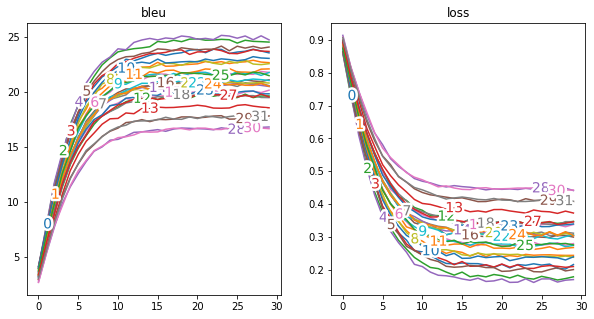

In [10]:
import matplotlib.pyplot as plt
from labellines import labelLines
import os

plt.figure(figsize=(10, 5))

task_num = len(list(filter(lambda x: x.startswith("task"), os.listdir("task.logs/"))))

for idx in range(task_num):
    ret = extract(
        lines=open(f"task.logs/task-{idx}.txt"), 
        filters=[include_filter("epoch")], 
        patterns={
            "epoch": f"epoch {RE.INT}",
            "bleu": f"bleu {RE.FLOAT}", 
            "loss": f"loss {RE.FLOAT}"
        }
    )
    if len(ret["epoch"]) > 1:
        plt.subplot(1, 2, 1)
        plt.plot(ret["epoch"], ret["bleu"], label=f'{idx}')
        plt.subplot(1, 2, 2)
        plt.plot(ret["epoch"], ret["loss"], label=f'{idx}')

plt.subplot(1, 2, 1)
plt.title("bleu")
labelLines(plt.gca().get_lines(), align=False, fontsize=14)

plt.subplot(1, 2, 2)
plt.title("loss")
labelLines(plt.gca().get_lines(), align=False, fontsize=14)

pass

## Factor Analysis

Sometimes we want to perform analysis on which factors influence the result mostly.

We should firstly extract the results by:

```bash
manytasks show task --rule=rule.yaml
```

After that, we put it into a pandas DataFrame:

In [5]:
import re
import pandas as pd


data = []
for line in open("task.logs/result.txt"):
    if line[0] not in "0123456789":
        continue
    datum = {}
    splits = re.split("\s+", line.strip())
    key = None
    for ele in splits:
        if ele.startswith("--"):
            key = ele[2:]
            continue
        if key is not None:
            datum[key] = ele
            key = None
    datum['accuracy'] = float(splits[-2])
    # datum['loss'] = float(splits[-1])

    data.append(datum)
data = pd.DataFrame(data)
data

,arch,layer,opt,lr,decay,accuracy
0,lstm,2,adam,1e-2,0.01,23.897754
1,lstm,2,adam,1e-2,0.001,22.895865
2,lstm,2,adam,1e-3,0.01,24.842179
3,lstm,2,adam,1e-3,0.001,23.911704
4,lstm,2,adam,5e-4,0.01,25.158833
5,lstm,2,adam,5e-4,0.001,24.182594
6,lstm,4,adam,1e-2,0.01,21.880374
7,lstm,4,adam,1e-2,0.001,20.855832
8,lstm,4,adam,1e-3,0.01,22.898360
9,lstm,4,adam,1e-3,0.001,21.871949


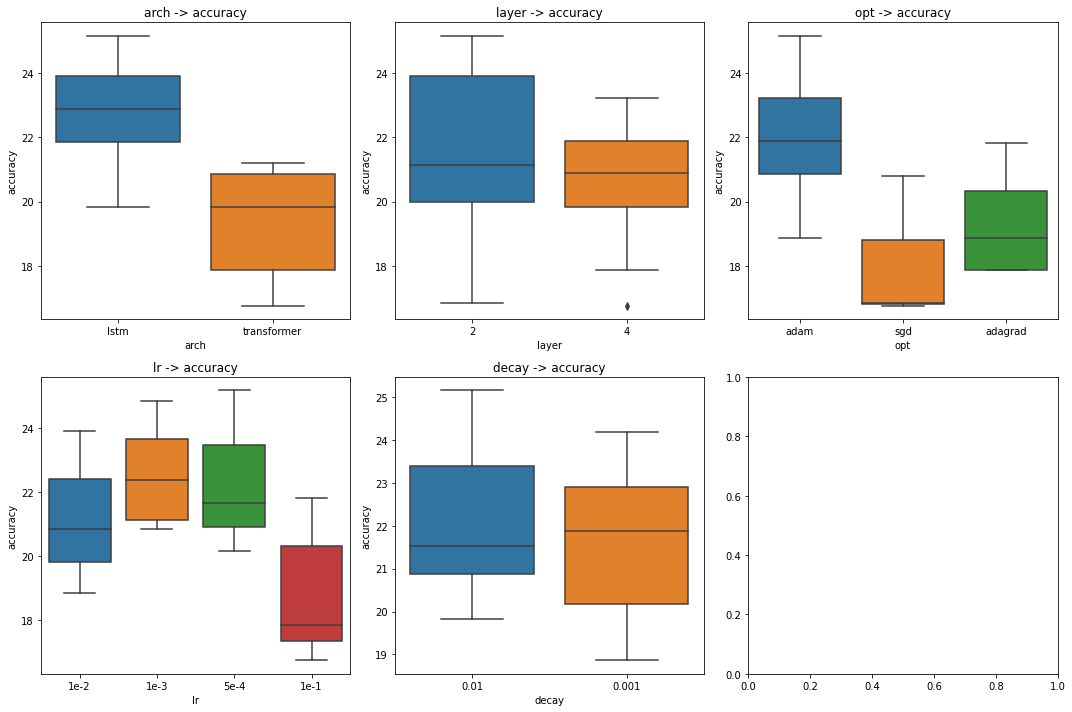

In [6]:
from matplotlib import pyplot as plt
import seaborn  as sns

num_y = 1
num_x = len(data.keys()) - num_y
total_num = num_x * num_y

row = 2
col = total_num // row + total_num % row

subfig_idx = 0
fig, axes = plt.subplots(row, col, figsize=(col * 5, row * 5))

for key in data.keys()[:num_x]:
    for val in data.keys()[num_x:]:
        subfig_idx += 1
        plt.subplot(row, col, subfig_idx)
        plt.title(f"{key} -> {val}")
        sns.boxplot(x=key, y=val, data=data)
fig.tight_layout()